# 0. Introdução

## 0.1. Configurações e Importação das Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import os
import string
import warnings
warnings.filterwarnings('ignore')

colors = ['#003f5c', '#00597b', '#007594', '#0092a3', '#00afa7', '#00cb9f', '#00e68e', '#63ff74']
palette = sns.set_palette(sns.color_palette(colors))
sns.set_theme(style='whitegrid', palette=palette)

SEED = 0

## 0.2 Importando os Dados

In [2]:
cwd = os.getcwd()

df_train = pd.read_csv(f'{cwd}\\train.csv')
df_test = pd.read_csv(f'{cwd}\\test.csv')
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [3]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

# 1. Análise Exploratória Dos Dados

## 1.1 Visão Geral
* `PassengerId` é o id único da linha e não tem nenhum efeito no *target*
* `Survived` é a variável *target* que estamos tentando prever (**0** or **1**):
    - **1 = Sobreviveu**
    - **0 = Não Sobreviveu**
* `Pclass` (Passenger Class) é o status socioeconômico do passageiro e é uma característica categórica que tem **3** valores únicos (**1**,  **2 **or **3**):
    - **1 = Classe Alta**
    - **2 = Classe Média**
    - **3 = Classe Baixa**
* `Name`, `Sex` and `Age` são autoexplicativas
* `SibSp` é o número total de irmão e cônjuges dos passageiros
* `Parch` é o número total de pais e filhos dos passageiros
* `Ticket` é o número do bilhete do passageiro
* `Fare` é a tarifa do passageiro
* `Cabin` é o número da cabine do passageiro
* `Embarked` é o porto de embargue e é uma característica categórica que tem **3** valores únicos (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Aqui na visão geral já da pra ver que temos valores faltantes, vamos dar uma olhada melhor neles:

# 1.2 Valores Faltantes

In [5]:
df_train.isnull().sum() # Valores nulos no DataFrame de treino

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df_test.isnull().sum() # Valores nulos do DataFrame de teste

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

É conveniente trabalhar com a concatenação do conjunto de teste e treino, caso contrário, os dados preenchidos podem *overfitar*. A quantidade de valore nulos em `Age`, `Embbarked` e `Fare` são pequenos comparados a amostra total, mas aproximadamente **80%** de `Cabin` estão faltando. Valores faltantes em `Age`, `Embarked` e `Fare` podem ser preenchidos com medidas estatísticas descritivas, mas isso não funcionaria para `Cabin`.

**overfitar** é um termo informal para representar quando ocorre *overfit*. *Overfit* é quando o modelo se acostuma tanto com os dados de treino que ele praticamente 'decora' um resultado, a consequência disso é que ele terá um desempenho excelente no treino, porém quando submetido aos dados de teste o desempenho será ruim. A tradução formal de *overfit* é sobreajuste.

### 1.2.1 Age

Valores faltantes de `Age` podem ser preenchidos com a idade média, porém usando a idade média de todo o conjunto de dados não é uma boa escolha. A melhor escolha seria a idade média dos grupos `Pclass` devido à sua alta correlação com `Age` e `Survived`. Veja a demonstração abaixo:

- `df.corr()` : é usado para encontrar correlações em pares de todas as colunas do DataFrame.
- `abs()` : retorna o valor absoluto de um dado número, ou seja, sua magnitude.
- `unstack()` : retorna um Dataframe com um novo nível de *labels* de coluna cujo nível mais interno consiste nos *labels* de índice dinâmico.
- `sort_values()` : ordena os valores em qualquer um dos eixos.
    - `kind` : parâmetro que permite escolher o algoritmo de ordenação que será utilizado.
    - `ascending` : parâmetro para definir se a ordenação será feita de maneira crescente (True) ou decrescente (False).
- `reset_index()` : reseta os índices.


In [7]:
# Cria um Dataframe com a correlações das variáveis
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
# Muda o nome das colunas do DataFrame
df_all_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation Coefficient'}, inplace=True)
# Seleciona somente as correlações de 'Age'
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Para ser mais preciso, a variável `Sex` é usada como segundo nível de *groupby* enquanto preenche os valores de idade ausentes. Como pode ser visto abaixo, os grupos `Pclass` e `Sex` têm valores medianos distintos. Quando a classe de passageiros aumenta, a idade média para homens e mulheres também aumenta. No entanto, as mulheres tendem a ter uma idade mediana ligeramente inferior à dos homens. As idades medianas abaixo são usadas para preencher os valores ausentes na *feature* `Age`.

In [8]:
# Cria um DataFrame com a mediana das idades por sexo e classe 
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

# Organizando os dados para plotar
data = []
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        data += [{
            'Pclass': pclass,
            'median_age': age_by_pclass_sex[sex][pclass],
            'sex': sex 
        }]

# DataFrame para plotar o gráfico
age_by_pclass_sex = pd.DataFrame(data)


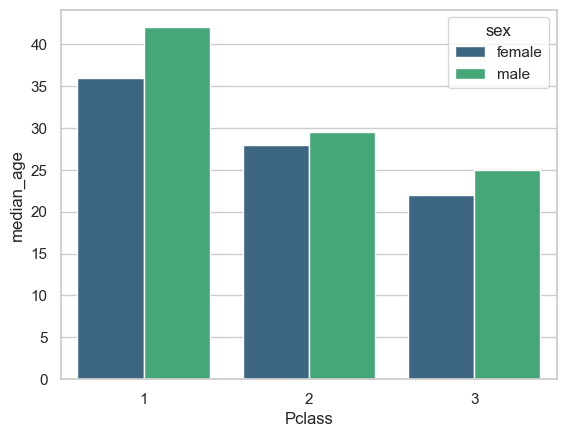

In [9]:
sns.barplot(x=age_by_pclass_sex['Pclass'], y=age_by_pclass_sex['median_age'], hue='sex', data=age_by_pclass_sex, palette='viridis');

Feito essa análise, vamos preencher os valores ausentes de `Age` com a mediana dos grupos `Sex` e `Pclass`

In [10]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### 1.2.2 Embarked
`Embarked` é uma *feature* categórica e só possui **2** valores ausentes. Ambos passageiros são mulheres, classe alta e possuem o mesmo número de bilhete. Isso significa que elas se conhecem e embarcaram juntas no mesmo porto. Vamos ver qual porto mais passageiros com essas características embarcaram:

In [11]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [12]:
df_all.query("Sex == 'female' and Pclass == 1")['Embarked'].value_counts(ascending=False)

C    71
S    69
Q     2
Name: Embarked, dtype: int64

O porto que embarcou mais passageiros com essas características foi o de *Cherbourg*, entretando com um valor muito próximo do porto de *Southampton*. Feito essa análise eu vou ir mais a fundo sobre essa informação para deixar aqui registrado uma mensagem muito importante para mim...

Pesquisando os valores do salário líquido mensal médio (após impostos) de *Cherbourg* e *Southampton* que possuem números de passageiros embarcados bem próximos, encontrei:
- **Cherbourg:** $1.875,74
- **Southampton:** $2.679,46


Com base nisso, eu poderia pensar que a *Mrs. George Nelson* embarcou no porto de *Southampton* pois o salário médio é maior e ela embarcou na classe alta.

Para tirar a prova dessa suposição, pesquisei o nome dela no google e veja o que eu encontrei:
> *'Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.'*
Informação encontrada nessa página, [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)

Uau, acho que estou ficando em análise de dados! Não cara, não...

✉️ **Uma carta para mim...**

Não tente tirar informações de onde não existe, tenha sempre um olhar crítico quanto aos dados e suas causalidades. Não economize perguntas, reflita o máximo que puder. A *Mrs. George Nelson* poderia ter embarcado em qualquer outro porto, um salário médio maior não garante que ela tinha um salário alto. 

Então vamos preencher os valores ausentes de `Embarked` com *S* já que o porto com maior número de embarque com as características *mulher* e *classe alta* é o de *Cherbbourg*

In [13]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### 1.2.3 Fare

In [14]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


Só existe um passageiro com valor ausente de `Fare`. Podemos supor que `Fare` é relacionado com as *features* tamanho da família (`Parch` e `SibSp`) e `Pclass`. O valor mediano do `Fare` para um homem com um bilhete da terceira classe e sem família é uma escolha lógica para preencher esse valor ausente.

In [27]:
# [3] Somente os de terceira classe; [0] Parch = 0; [0] SibSp = 0
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

# Preenchendo o valor ausente com a média de Fare de um passageiro sozinho e da terceira classe
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

7.8542

### 1.2.4. Cabin

A maior parte da *feature* `Cabin` estão com valores ausentes, entretanto isso não pode ser ignorado completamente porque algumas cabines podem ter taxas de sobrevivência mais altas. A primeira letra dos valores da cabine são os decks nos quais as cabines estão localizadas. Esses decks foram separados principalmente para uma classe de passageiros, mas alguns deles foram usados por várias classe de passageiros. Vamos pegar algumas informações sobre os decks no site a seguir [Titanic Fandom](https://titanic.fandom.com/wiki/Watertight_Bulkheads)

![Titanic's Watertight Compartments](Titanics-Watertight-Compartments.jpeg)

- [Boat Deck](https://titanic.fandom.com/wiki/Boat_Deck) No *Boat Deck* exite **7** quartos rotulados de **T, U, V, W, X, Y, Z**, mas apenas a cabine **T** está presente no conjunto de dados.
- [Deck A](https://titanic.fandom.com/wiki/A_Deck), [Deck B](https://titanic.fandom.com/wiki/B_Deck), [Deck C](https://titanic.fandom.com/wiki/C_Deck) São apenas para passageiros da primeira classe.
- [Deck D](https://titanic.fandom.com/wiki/D_Deck) e [Deck E](https://titanic.fandom.com/wiki/E_Deck) São para passageiros de todas as classes.
- [Deck F](https://titanic.fandom.com/wiki/F_Deck) e [Deck G](https://titanic.fandom.com/wiki/G_Deck) São para passageiros de segunda e teirceira classe.
- De **A** até **G**, a distância até a escada aumenta, o que pode ser um fator de sobrevivência.

Vamos vizualizar isso em um gráfico:


In [33]:
df_all.drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket'])

,Name,Pclass,Deck
0,"Braund, Mr. Owen Harris",3,M
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,C
2,"Heikkinen, Miss. Laina",3,M
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,C
4,"Allen, Mr. William Henry",3,M
...,...,...,...
1304,"Spector, Mr. Woolf",3,M
1305,"Oliva y Ocana, Dona. Fermina",1,C
1306,"Saether, Mr. Simon Sivertsen",3,M
1307,"Ware, Mr. Frederick",3,M


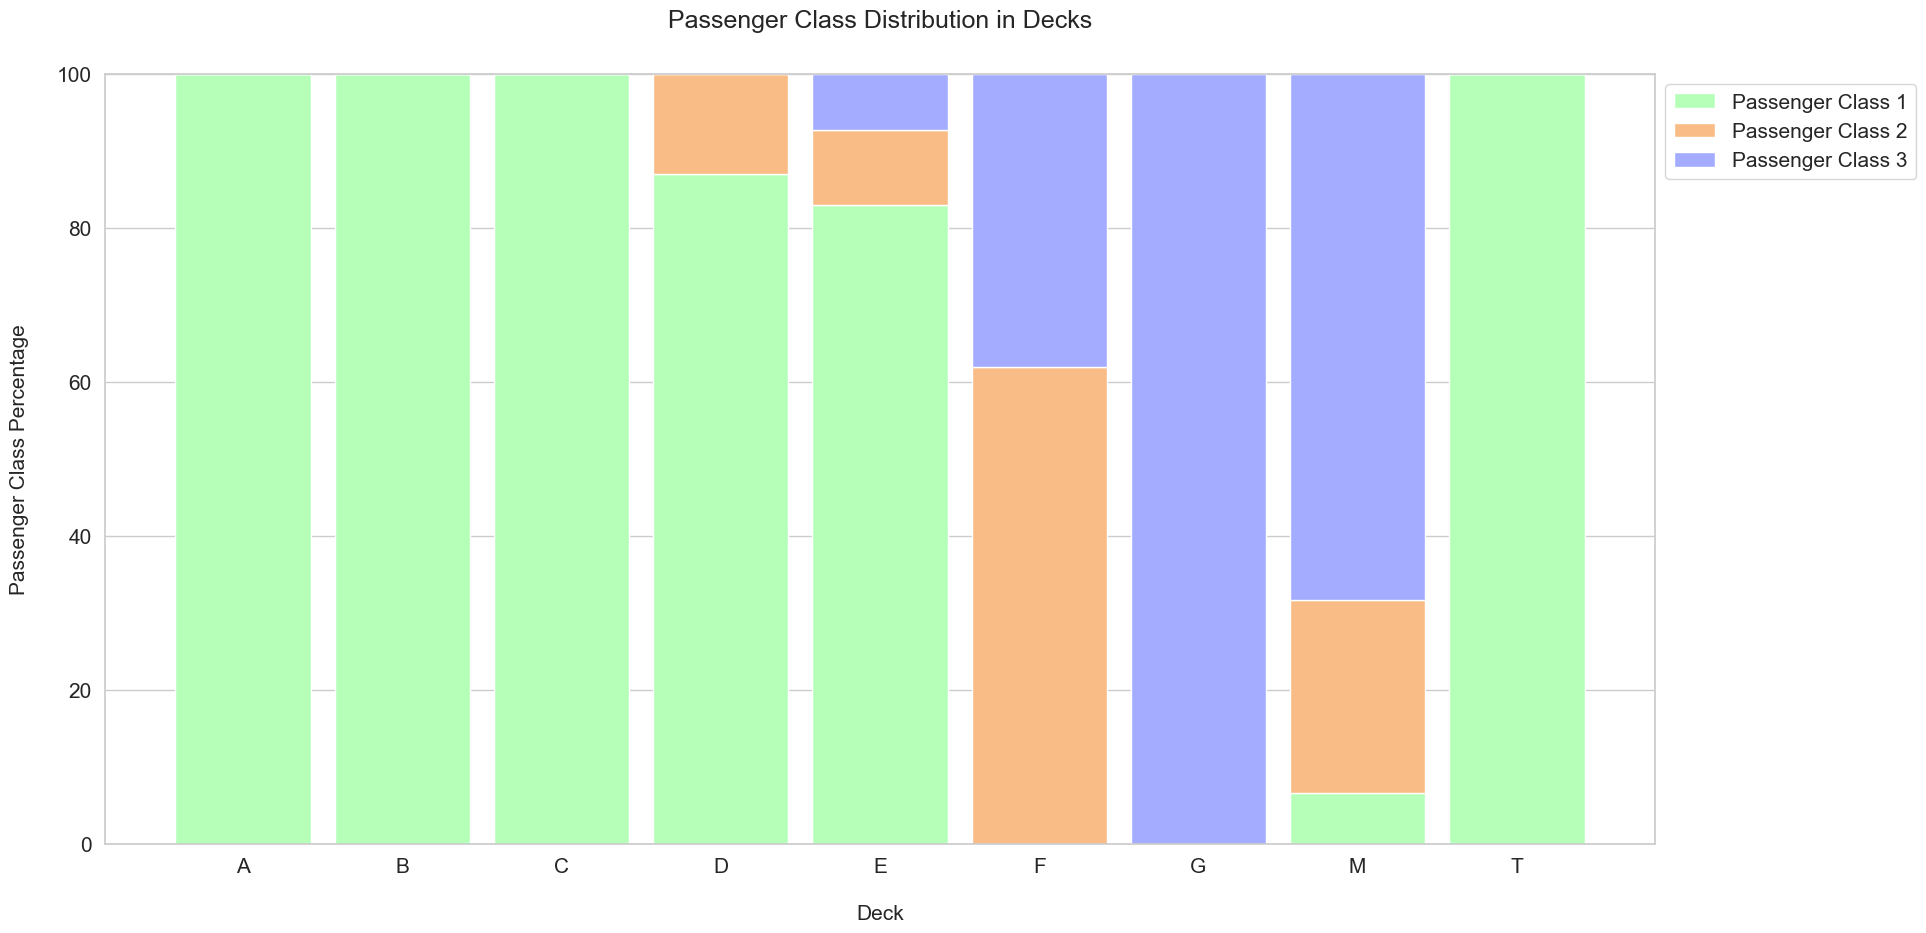

In [44]:
# Criando uma coluna Deck com a primeira letra da Cabine (M para valores ausentes)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all[['Name', 'Deck', 'Pclass']].groupby(['Deck', 'Pclass']).count().rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):

    # Criando um dicionário para cada count de classe de passageiros em todos os decks
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]

    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
    
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}

    # Criando um dicionário para cada porcentagem de classe de passageiro em cada deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
    
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()  

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)


- **100%** dos decks **A, B e C** são de passageiros de primeira classe.
- Deck **D** tem **87%** de passageiros da primeira classe e **13%** da segunda classe.
- Deck **E** tem **83%** de passageiros da primeira classe, **10%** da segunda classe e **7%** da terceira classe.
- Deck **F** tem **62%** de passageiros da segunda classe e **38%** da terceira classe.
- **100%** do deck **G** são da terceira classe.
- Há uma pessoa no deck do barco na cabine **T** e ele é um passageiro da primeira classe. O passageiro na cabine **T** tem a melhor semelhança com os passageiros do deck **A**, então ele é agrupado com o deck **A**.
- Os passageiros rotulados com o valor **M** são os valores ausentes na *feature* `Cabin`. Eu não acho que seja possível encontrar o deck real desses passageiros então vamos usar **M** como um deck.

In [45]:
# Passageiro no deck T é mudado para A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

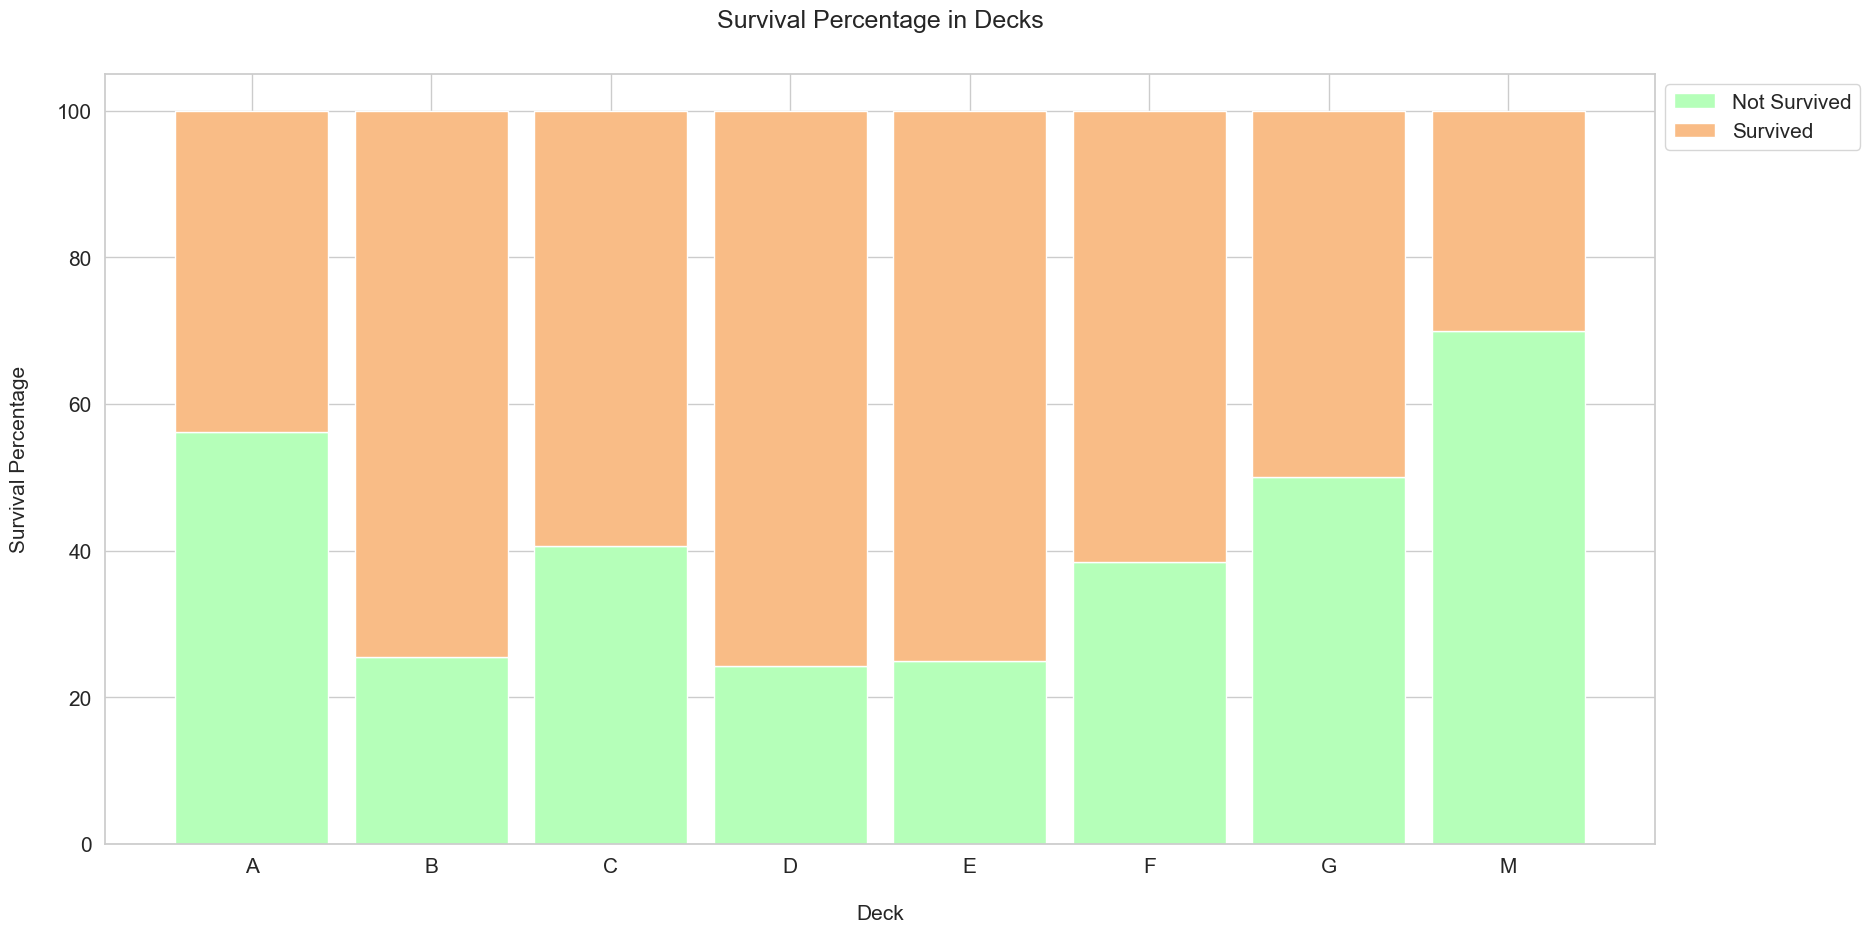

In [46]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)